In [1]:
! pip3 install scikit-learn

In [2]:
import os, glob, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from scipy.stats import linregress
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

import warnings

warnings.filterwarnings("ignore", category=FutureWarning, message=".*use_inf_as_na.*")


In [3]:
fn='final_combine_data.csv'
outfd=pd.read_csv(fn)
print(outfd.head())
outfd['date'] = pd.to_datetime(outfd['datetime'])


     datetime  Daily_DS_cm  13D_smooth_DS_cm  Daily_sm_set1  Daily_sm_set5  \
0  2023-06-08       0.2973            0.3803          11.90          29.88   
1  2023-06-09       0.2860            0.3655          12.62          29.14   
2  2023-06-10       0.2772            0.3513          12.97          28.36   
3  2023-06-11       0.2718            0.3383          12.79          27.40   
4  2023-06-12       0.2656            0.3262          12.37          26.62   

   13D_sm_set1  13D_sm_set5  301_gw_elev  302_gw_elev  303_gw_elev  \
0      11.4392      33.5392    1707.6860    1707.4302    1706.9940   
1      11.4831      32.9538    1707.6733    1707.4177    1706.9840   
2      11.5523      32.3454    1707.6692    1707.4083    1706.9754   
3      11.6131      31.6908    1707.6529    1707.3990    1706.9688   
4      11.6569      31.0038    1707.6421    1707.3958    1706.9673   

   13D_smooth_GW301_m  13D_smooth_GW302_m  13D_smooth_GW303_m  Daily_precip_mm  
0           1707.7723        

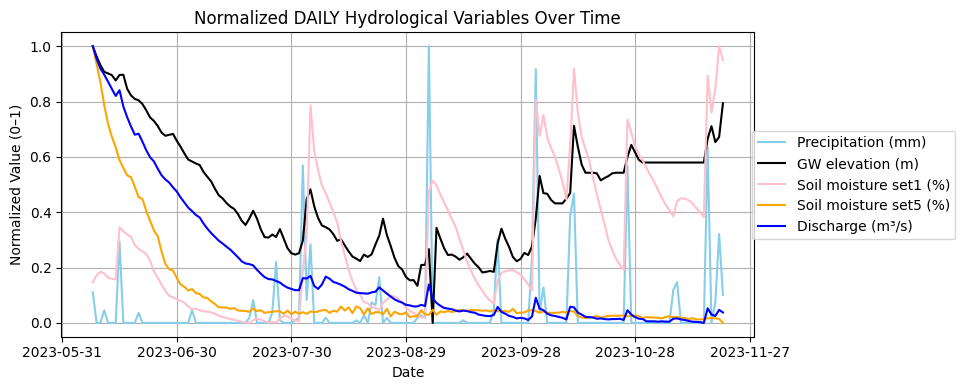

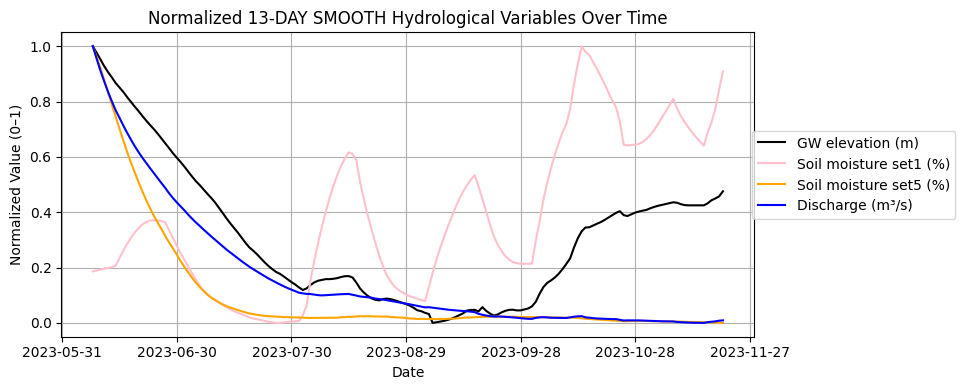

In [4]:

# Min-max normalization
GW_norm = (outfd['303_gw_elev'] - outfd['303_gw_elev'].min()) / (outfd['303_gw_elev'].max() - outfd['303_gw_elev'].min())
SM_norm = (outfd['Daily_sm_set1'] - outfd['Daily_sm_set1'].min()) / (outfd['Daily_sm_set1'].max() - outfd['Daily_sm_set1'].min())
SM_norm5 = (outfd['Daily_sm_set5'] - outfd['Daily_sm_set5'].min()) / (outfd['Daily_sm_set5'].max() - outfd['Daily_sm_set5'].min())
DS_norm = (outfd['Daily_DS_cm'] - outfd['Daily_DS_cm'].min()) / (outfd['Daily_DS_cm'].max() - outfd['Daily_DS_cm'].min())
Pc_norm = (outfd['Daily_precip_mm'] - outfd['Daily_precip_mm'].min()) / (outfd['Daily_precip_mm'].max() - outfd['Daily_precip_mm'].min())

SMOOTH_GW_norm = (outfd['13D_smooth_GW303_m'] - outfd['13D_smooth_GW303_m'].min()) / (outfd['13D_smooth_GW303_m'].max() - outfd['13D_smooth_GW303_m'].min())
SMOOTH_SM_norm1 = (outfd['13D_sm_set1'] - outfd['13D_sm_set1'].min()) / (outfd['13D_sm_set1'].max() - outfd['13D_sm_set1'].min())
SMOOTH_SM_norm5 = (outfd['13D_sm_set5'] - outfd['13D_sm_set5'].min()) / (outfd['13D_sm_set5'].max() - outfd['13D_sm_set5'].min())
SMOOTH_DS_norm = (outfd['13D_smooth_DS_cm'] - outfd['13D_smooth_DS_cm'].min()) / (outfd['13D_smooth_DS_cm'].max() - outfd['13D_smooth_DS_cm'].min())
# SMOOTH_Pc_norm = (outfd['Daily_precip_mm'] - outfd['Daily_precip_mm'].min()) / (outfd['Daily_precip_mm'].max() - outfd['Daily_precip_mm'].min())


plt.figure(figsize=(10,4))   
# Plot normalized values
plt.plot(outfd['date'], Pc_norm, label='Precipitation (mm)', color='skyblue', )
plt.plot(outfd['date'], GW_norm, label='GW elevation (m)', color='k')
plt.plot(outfd['date'], SM_norm, label='Soil moisture set1 (%)', color='pink')
plt.plot(outfd['date'], SM_norm5, label='Soil moisture set5 (%)', color='orange')
plt.plot(outfd['date'], DS_norm, label='Discharge (m³/s)', color='blue')

plt.legend(loc="upper right", bbox_to_anchor=(1.3,0.7))
plt.xlabel('Date')
plt.ylabel('Normalized Value (0–1)')
plt.title('Normalized DAILY Hydrological Variables Over Time')
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=30))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.grid(True)
plt.tight_layout()
plt.show()


plt.figure(figsize=(10,4))   
# Plot normalized values
plt.plot(outfd['date'], SMOOTH_GW_norm, label='GW elevation (m)', color='k')
plt.plot(outfd['date'], SMOOTH_SM_norm1, label='Soil moisture set1 (%)', color='pink')
plt.plot(outfd['date'], SMOOTH_SM_norm5, label='Soil moisture set5 (%)', color='orange')
plt.plot(outfd['date'], SMOOTH_DS_norm, label='Discharge (m³/s)', color='blue')

plt.legend(loc="upper right", bbox_to_anchor=(1.3,0.7))
plt.xlabel('Date')
plt.ylabel('Normalized Value (0–1)')
plt.title('Normalized 13-DAY SMOOTH Hydrological Variables Over Time')
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=30))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.grid(True)
plt.tight_layout()
plt.show()

In [5]:
seis_sta=pd.read_csv('redbutte_sta.csv')
seis_sta['stnm']=seis_sta['stnm'].astype(int).apply(lambda i: f"{i:03}")
seis_sta=seis_sta[:-1] 
print(seis_sta)

output_path="Results_prefilt_20Hz_coefs//DVAVE_c2wei/ST/SC/"
bandlist=['4-8','2-4',]

  stnm        lat         lon    elev
0  002  40.794796 -111.779490  1868.0
1  001  40.794836 -111.779309  1868.0
2  003  40.794740 -111.779110  1847.0
3  004  40.794670 -111.778810  1847.0
4  005  40.794660 -111.778630  1847.0
5  006  40.794660 -111.778400  1847.0


In [6]:
# 002 -> N051
# 001 -> N037
# 003 -> N018
# 004 -> S009
# 005 -> S024
# 006 -> S043

# Mapping dictionary
rename_map = {
    "002": "N051",
    "001": "N037",
    "003": "N018",
    "004": "S009",
    "005": "S024",
    "006": "S043"
}

# Example: renaming a list of station codes
stations = ["002", "001", "003", "004", "005", "006"]

renamed_stations = [rename_map[st] for st in stations]
print(renamed_stations)
# Output: ['N037', 'N051', 'N018', 'S009', 'S024', 'S043']
seis_sta['stnm_renamed']=renamed_stations
print(seis_sta)


['N051', 'N037', 'N018', 'S009', 'S024', 'S043']
  stnm        lat         lon    elev stnm_renamed
0  002  40.794796 -111.779490  1868.0         N051
1  001  40.794836 -111.779309  1868.0         N037
2  003  40.794740 -111.779110  1847.0         N018
3  004  40.794670 -111.778810  1847.0         S009
4  005  40.794660 -111.778630  1847.0         S024
5  006  40.794660 -111.778400  1847.0         S043


In [7]:
stnm='004'
renamed=seis_sta.loc[seis_sta['stnm']==stnm, 'stnm_renamed'].values[0]
fband='2-4'
coef='0.6'
# fn_pattern=f'{output_path}/dv_ave_*_{stnm}_*_F{fband}*.out'
fn_pattern = f'{output_path}/dv_ave_*_coef{coef}_{stnm}_*_F{fband}*.out'
fn=glob.glob(fn_pattern)
pd_dv = pd.read_csv(
    fn[0], 
    sep='\s+', 
    names=['dv', 'err', 'date', 'sta1', 'sta2', 'jday'], 
    skiprows=0
)
pd_dv['dv']=pd_dv['dv']*100
pd_dv['err']=pd_dv['err']*100
# Convert the 'date' column to datetime
pd_dv['date'] = pd.to_datetime(pd_dv['date'], format='%Y%m%d')
errcut=0.4
filtered_dv = pd_dv[pd_dv['err'] <= errcut]
df24= filtered_dv.copy()

fband='4-8'
fn_pattern = f'{output_path}/dv_ave_*_coef{coef}_{stnm}_*_F{fband}*.out'
fn=glob.glob(fn_pattern)
pd_dv = pd.read_csv(
    fn[0], 
    sep='\s+', 
    names=['dv', 'err', 'date', 'sta1', 'sta2', 'jday'], 
    skiprows=0
)
pd_dv['dv']=pd_dv['dv']*100
pd_dv['err']=pd_dv['err']*100
# Convert the 'date' column to datetime
pd_dv['date'] = pd.to_datetime(pd_dv['date'], format='%Y%m%d')
errcut=0.4
filtered_dv = pd_dv[pd_dv['err'] <= errcut]
df48= filtered_dv.copy()

In [8]:
# First make sure date columns are datetime (if not already)
outfd['date'] = pd.to_datetime(outfd['date'])
df24['date'] = pd.to_datetime(df24['date'])
df48['date'] = pd.to_datetime(df48['date'])

# Merge the dv values into outfd based on matching date
df = outfd.copy()
df = df.merge(df24[['date', 'dv']], on='date', how='left')  # add dv_2_4Hz
df = df.rename(columns={'dv': 'dv_2_4Hz'})

df = df.merge(df48[['date', 'dv']], on='date', how='left')  # add dv_4_8Hz
df = df.rename(columns={'dv': 'dv_4_8Hz'})
df=df.dropna()

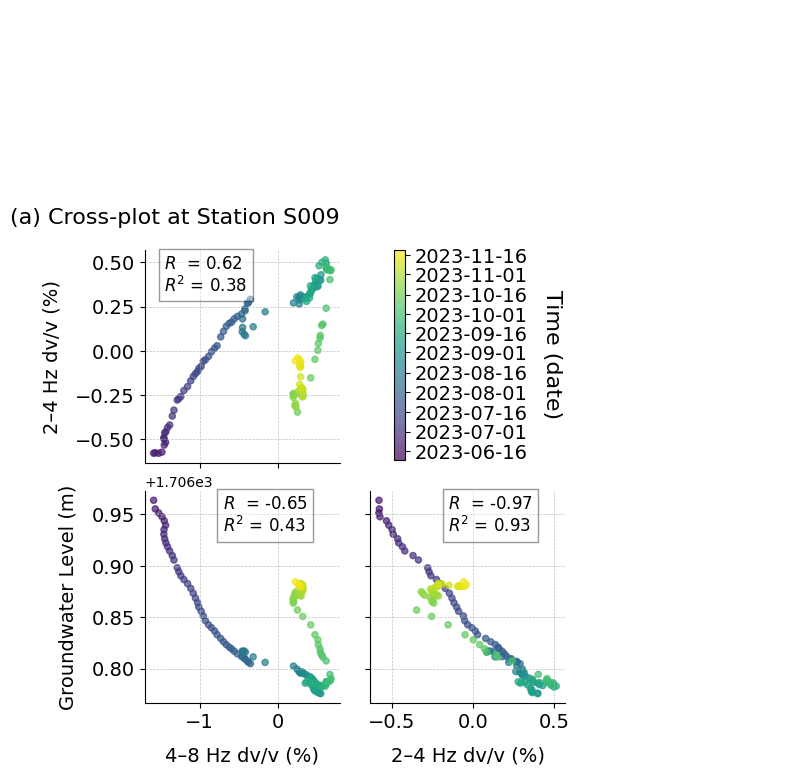

In [9]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize
import seaborn as sns
from scipy.stats import linregress

# Clean the data
# df_corr = df[['datetime', 'dv_2_4Hz', 'dv_4_8Hz',  '13D_smooth_GW303_m',  '13D_smooth_DS_cm','13D_sm_set1', '13D_sm_set5',]].dropna()

df_corr = df[['datetime',  'dv_4_8Hz', 'dv_2_4Hz', '13D_smooth_GW303_m', ]].dropna()


# Make sure datetime is parsed correctly
df_corr['datetime'] = pd.to_datetime(df_corr['datetime'])
df_corr['timestamp'] = df_corr['datetime'].map(lambda x: x.timestamp())

# Define your custom date range as strings
bound_dates = ['2023-06-09', '2023-11-20']
# Convert to datetime and then to timestamps
bound_timestamps = [pd.to_datetime(d).timestamp() for d in bound_dates]
# Unpack the min and max for Normalize
norm = Normalize(vmin=bound_timestamps[0], vmax=bound_timestamps[1])
cmap = plt.get_cmap("viridis")
colors = df_corr['datetime'].apply(lambda dt: cmap(norm(dt.timestamp())))


# Update plotting function
def scatter_with_stats(x, y, color_values=None, **kwargs):
    ax = plt.gca()
    
    # Scatter with color
    scatter = ax.scatter(x, y, c=color_values, s=20, alpha=0.7, )
    # plt.setp(scatter, edgecolor='grey', linewidth=0.25, )
    
    # Regression line
    slope, intercept, r_value, p_value, std_err = linregress(x, y)
    x_vals = np.array(ax.get_xlim())
    y_vals = intercept + slope * x_vals
    # ax.plot(x_vals, y_vals, color='red', linewidth=1)
    
    # Annotate R
    r2 = r_value**2
    # label = f"Slope={slope:.2f}\nR={r_value:.2f}"
    # label = f"$R^2 = {r2:.2f}$\n$R = {r_value:.2f}$"
    # label = f"Corr = {r_value:.2f}"

    # Line
    # x_vals = np.array(ax.get_xlim())
    # y_vals = intercept + slope * x_vals
    # ax.plot(x_vals, y_vals, color='red', linewidth=1)

    # === Annotation text ===
    label = (
        f"$R$  = {r_value:.2f}\n"
        f"$R^2$ = {r2:.2f}"
        # f"$p$ = {p_value:.2e}"
    )
    
    # pick position automatically
    if r_value <0:
        x, y = 0.4, 0.98   # top-right
    if r_value > 0.7:
        x, y = 0.4,0.25
    if r_value > 0.3 and r_value <= 0.7:
        x, y = 0.1,0.98
    if r_value > 0 and r_value <= 0.3:
        x, y = 0.5, 0.95   
    ax.text(x, y, label, transform=ax.transAxes,
        fontsize=12, verticalalignment='top', bbox=dict(facecolor='white', alpha=0.4))


# Create PairGrid with coloring
plot_vars = [ 'dv_4_8Hz','dv_2_4Hz', '13D_smooth_GW303_m', ]
g = sns.PairGrid(df_corr, vars=plot_vars, diag_sharey=False, height=2, aspect=1.2)
g.map_lower(lambda x, y, **kwargs: scatter_with_stats(x, y,s =30, color_values=colors.loc[x.index], **kwargs))
# g.map_diag(sns.histplot, kde=True, color='skyblue')
g.map_diag(lambda *args, **kwargs: None)  # do nothing on diagonal

# Hide upper triangle
for i in range(len(g.axes)):
    for j in range(len(g.axes)):
        if j >= i:
            g.axes[i, j].set_visible(False)

# Label font size
for ax in g.axes.flatten():
    if ax:
        ax.set_xlabel(ax.get_xlabel(), fontsize=14)
        ax.set_ylabel(ax.get_ylabel(), fontsize=14)
        ax.tick_params(labelsize=14)

# plt.suptitle(f"Station {renamed} ", y=1.02)

# Create ScalarMappable for the colorbar
sm = plt.cm.ScalarMappable(cmap='viridis', norm=norm)
sm.set_array([])


# === Add single shared colorbar ===
cbar_ax = g.fig.add_axes([0.45, 0.5, 0.015, 0.35])  # [left, bottom, width, height]
sm = ScalarMappable(cmap=cmap, norm=norm)
cbar = plt.colorbar(sm, cax=cbar_ax, alpha=0.7)
# 1. Define your custom tick dates
# Create date ranges for the 1st and 16th of each month
start_dates = pd.date_range(start="2023-06-08", end="2023-11-20", freq='MS')
mid_dates = pd.date_range(start="2023-06-01", end="2023-11-16", freq='MS') + pd.Timedelta(days=15)

# Combine and sort
custom_dates = start_dates.union(mid_dates).sort_values()

# 2. Convert to timestamps (for tick positions)
tick_vals = custom_dates.map(lambda dt: dt.timestamp())
# 3. Format labels nicely
tick_labels = custom_dates.strftime('%Y-%m-%d')

cbar.set_ticks(tick_vals)
cbar.set_ticklabels(tick_labels, fontsize=14)
cbar.set_label("Time (date)", rotation=270, labelpad=10, fontsize=16, va='bottom')

label_map = {
    "dv_2_4Hz": "2–4 Hz dv/v (%)",
    "dv_4_8Hz": "4–8 Hz dv/v (%)",
    "13D_smooth_GW303_m": "Groundwater Level (m)"
}


# Final layout
g.fig.subplots_adjust(top=1.25, right=1,)
g.fig.suptitle(f"(a) Cross-plot at Station {renamed} ",  y=0.92, x=0.15, fontsize=16)
# Adjust label padding
for ax in g.axes.flatten():
    xlabel = ax.get_xlabel()
    ylabel = ax.get_ylabel()
    ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.8)
    if xlabel in label_map:
        ax.set_xlabel(label_map[xlabel], labelpad=10)
    if ylabel in label_map:
        ax.set_ylabel(label_map[ylabel], labelpad=10)

# plt.show()
plt.savefig(f"Fig_S009_pairgrid.png", dpi=300, bbox_inches='tight')


In [10]:
def plot_resid(df, **kwargs):
    df['datetime']=pd.to_datetime(df['datetime'])
    # 4. Plot the original data, fitting results, and residuals
    plt.figure(figsize=(12,8))

    # Original Data and Fitting Results for dv_2_4Hz
    plt.subplot(3, 2, 3)
    plt.grid(True, color='grey', linestyle='--', linewidth=0.5)
    plt.axhline(0, color='grey', linestyle='-')   
    plt.gca().invert_yaxis()
    plt.plot(df['datetime'], df['dv_2_4Hz'], '.', markersize=5, linestyle='-', linewidth=0.5 ,alpha=0.7,
             label='Observed dv/v', color='blue')
    plt.plot(df['datetime'], df['dv_pred_2_4'], '.', markersize=5, linestyle='-', linewidth=0.5 ,alpha=0.7,
             label='Modeled dv/v by GWL', color='orange')
    plt.plot(df['datetime'], df['residuals_2_4'],'.', markersize=5, linestyle='-', linewidth=0.5 ,alpha=0.7,
             label='Residuals', color='red')

    plt.title('(c) Modeling of dv/v at deep depths (2-4 Hz)', fontsize=16)
    plt.xlabel('Time', fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.ylabel('dv/v (%)', fontsize=14)
    plt.legend(loc="upper right",)

    # Original Data and Fitting Results for dv_4_8Hz
    plt.subplot(3, 2, 1)
    plt.grid(True, color='grey', linestyle='--', linewidth=0.5) 
    plt.axhline(0, color='grey', linestyle='-')   
    plt.gca().invert_yaxis()
    plt.plot(df['datetime'], df['dv_4_8Hz'],'.', markersize=5, linestyle='-', linewidth=0.5 , alpha=0.7,
             label='Observed dv/v', color='blue')
    plt.plot(df['datetime'], df['dv_pred_4_8'], '.', markersize=5, linestyle='-', linewidth=0.5 ,alpha=0.7,
             label='Modeled dv/v by GWL', color='orange', )
    plt.plot(df['datetime'], df['residuals_4_8'],'.', markersize=5, linestyle='-', linewidth=0.5 , alpha=0.7,
             label='Residuals ', color='red')
    
    plt.title('(b) Modeling of dv/v at shallow depths (4-8 Hz)', fontsize=16)
    plt.xlabel('Time', fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.ylabel('dv/v (%)', fontsize=14)
    plt.legend()


    # Display the plots
    plt.tight_layout()
    plt.savefig(f"Fig_S009_dvv_modeling.png", dpi=300, bbox_inches='tight')


Index(['13D_smooth_GW303_m'], dtype='object')
Index(['13D_smooth_GW303_m'], dtype='object') [-5.99608253] 10234.386459007257
Coefficients for dv_2_4Hz model:
13D_smooth_GW303_m coef: -5.9961
Intercept: 10234.3865

Coefficients for dv_4_8Hz model:
13D_smooth_GW303_m: -9.3680
Intercept: 15989.5974


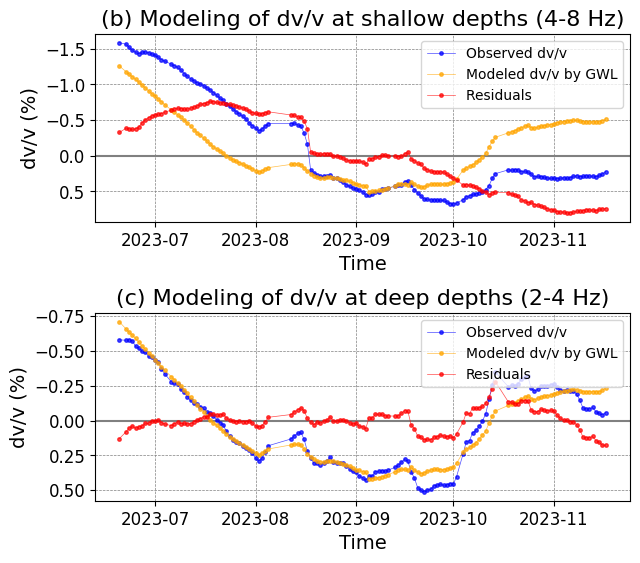

In [11]:
dftmp=df.copy()
# Perform linear regression to model dv_2_4Hz and dv_4_8Hz as functions of GWL
# Model 1: dv_2_4Hz as a function of GWL
X_gwl = dftmp[['13D_smooth_GW303_m']]
y_2_4 = dftmp['dv_2_4Hz']

# Fit the model
model_2_4 = LinearRegression()
model_2_4.fit(X_gwl, y_2_4)

# Model 2: dv_4_8Hz as a function of GWL
y_4_8 = dftmp['dv_4_8Hz']
model_4_8 = LinearRegression()
model_4_8.fit(X_gwl, y_4_8)

# Predict dv_2_4Hz and dv_4_8Hz using both models
dftmp['dv_pred_2_4'] = model_2_4.predict(X_gwl)
dftmp['dv_pred_4_8'] = model_4_8.predict(X_gwl)

# Calculate residuals for both models
dftmp['residuals_2_4'] = dftmp['dv_2_4Hz'] - dftmp['dv_pred_2_4']
dftmp['residuals_4_8'] = dftmp['dv_4_8Hz'] - dftmp['dv_pred_4_8']


# Get the list of predictor names
predictors = X_gwl.columns
print(predictors)
print(predictors, model_2_4.coef_, model_2_4.intercept_)

# Print the coefficients with corresponding variable names
print("Coefficients for dv_2_4Hz model:")
for name, coef in zip(predictors, model_2_4.coef_):
    print(f"{name} coef: {coef:.4f}")
    print(f"Intercept: {model_2_4.intercept_:.4f}")

print("\nCoefficients for dv_4_8Hz model:")
for name, coef in zip(predictors, model_4_8.coef_):
    print(f"{name}: {coef:.4f}")
    print(f"Intercept: {model_4_8.intercept_:.4f}")

plot_resid(dftmp,)